In [23]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from k_means_constrained import KMeansConstrained
import warnings
import folium
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [131]:

def cluster_data(file, n_clusters, size_max=None, weight_max=None):
    # Read the CSV file 
    data = pd.read_csv(file)
    data = data.head(900)
    
    kmeans = KMeans(n_clusters=n_clusters, 
                    init='k-means++', 
                    algorithm='auto', 
                    random_state=42,
                    max_iter=1,
                    n_init=1,
                    copy_x=True)
    labels = kmeans.fit_predict(data[['longitude', 'latitude']])
    
    # Calculate cluster sizes and total weights (if constraints are provided)
    if size_max is not None:
        counts = np.bincount(labels)
        total_orders = len(data)
        total_size_max = sum(size_max)
        if total_orders > total_size_max:
            raise ValueError(f"Route Planning can't happen with the defined number of orders constraints."
                             f"Total orders in data: {total_orders}, defined constraints account for only {total_size_max} orders.")
        
    if weight_max is not None:
        weights = np.bincount(labels, weights=data['Weight'])
        total_weight = np.sum(data['Weight'])
        total_weight_max = sum(weight_max)
        if total_weight > total_weight_max:
            raise ValueError(f"Route Planning can't happen with the defined weight constraints."
                             f"Total weight in data: {total_weight}, defined weight constraints account for only a weight of {total_weight_max}.")
    
    cluster_sizes = {}
    
    while (size_max is not None and np.any(counts > np.array(size_max))) or (weight_max is not None and np.any(weights > np.array(weight_max))):
        # Find clusters that exceed the maximum size or weight
        oversized_clusters = np.where((size_max is not None and counts > np.array(size_max)) 
                                      | (weight_max is not None and weights > np.array(weight_max)))[0]
        
        for cluster in oversized_clusters:
            # Get the indices of the data points in the current cluster
            cluster_indices = np.where(labels == cluster)[0]
            
            # Find the data point with the minimum distance to other centroids
            min_distance = float('inf')
            min_distance_index = -1
            
            for idx in cluster_indices:
                X = np.array(data[['longitude', 'latitude']])
                distance = np.sum((kmeans.cluster_centers_ - X[idx]) ** 2, axis=1)
                distance_to_other_centroids = np.sum(distance)
                if distance_to_other_centroids < min_distance:
                    min_distance = distance_to_other_centroids
                    min_distance_index = idx
            
            # Get the index of the selected data point in the original data
            selected_index = min_distance_index
            
            # Assign the selected data point to another cluster
            if size_max is not None:
                min_size_index = np.argmin(counts)
                labels[selected_index] = min_size_index
                counts[min_size_index] += 1
                counts[cluster] -= 1
            if weight_max is not None:
                min_weight_index = np.argmin(weights)
                labels[selected_index] = min_weight_index
                weights[min_weight_index] += data['Weight'][selected_index]
                weights[cluster] -= data['Weight'][selected_index]
        
    # Update cluster sizes after adjustments
    for i in range(n_clusters):
        cluster_sizes[i] = np.sum(labels == i)
    
    # Add the cluster column to the dataframe
    data['cluster'] = labels
    
    return data, cluster_sizes

### Mineral Man

In [207]:
n_clusters = 7
size_max = [10,13,15,20,10,20,40]
weight_max = [200, 300, 198, 235, 210, 212, 200]
data, cluster_sizes = cluster_data('C:/Users/leemn/Downloads/mineral_man.csv', 
                                                     n_clusters,
                                                     #size_max=size_max,
                                                     weight_max=weight_max
                                                    )

In [134]:
data2 = data[data['order_no']!='ALEE001']
data2.to_csv('data2.csv',index=None)

n_clusters = 7
size_max = [10,13,15,20,10,20,40]
weight_max = [200, 300, 198, 235, 210, 212, 200]
data, cluster_sizes = cluster_data('data2.csv', 
                                                     n_clusters,
                                                     #size_max=size_max,
                                                     weight_max=weight_max
                                                    )

In [105]:
data.groupby('cluster')['order_no'].count(), data.groupby('cluster')['Weight'].sum(), print(f"Cluster weight/stops",cluster_sizes)

Cluster weight/stops {0: 9, 1: 12, 2: 9, 3: 8, 4: 10, 5: 20, 6: 8}


(cluster
 0     9
 1    12
 2     9
 3     8
 4    10
 5    20
 6     8
 Name: order_no, dtype: int64,
 cluster
 0     87
 1    235
 2    142
 3     41
 4    231
 5    265
 6    184
 Name: Weight, dtype: int64,
 None)

### Somerset Timbers

In [203]:
n_clusters = 4   # 3 8tonners and 1 4tonner
size_max = [8,8,8,8]
weight_max = [8000,4000,8000,8000]
data, cluster_sizes = cluster_data('C:/Users/leemn/Downloads/somerset_timbers_data.csv', 
                                                     n_clusters=n_clusters,
                                                     #size_max=size_max,
                                                     weight_max=weight_max
                                                    )

In [120]:
data.groupby('cluster')['SO_No'].count(), data.groupby('cluster')['Weight'].sum(), print(f"Cluster weight/stops",cluster_sizes)

Cluster weight/stops {0: 10, 1: 6, 2: 3, 3: 11}


(cluster
 0    10
 1     6
 2     3
 3    11
 Name: SO_No, dtype: int64,
 cluster
 0    6239.4450
 1    3890.4100
 2    2884.0000
 3    2729.5055
 Name: Weight, dtype: float64,
 None)

### Takealot

In [199]:
n_clusters = 30
size_max = [100,90,150,200,200,130,120,150,200,150,189,190,150,200,190,
            100,90,150,200,200,130,120,150,200,150,189,190,150,200,190]
weight_max = [400,450,350,420,290,400,450,350,420,290,400,450,350,420,290]
data, cluster_sizes = cluster_data('C:/Users/leemn/Downloads/takealot.csv', 
                                                     n_clusters=n_clusters,
                                                     size_max=size_max,
                                                     #weight_max=weight_max
                                                    )

In [124]:
data.groupby('cluster')['order_id'].count(), print(f"Cluster weight/stops",cluster_sizes)

Cluster weight/stops {0: 93, 1: 45, 2: 32, 3: 13, 4: 27, 5: 36, 6: 20, 7: 36, 8: 3, 9: 12, 10: 15, 11: 4, 12: 34, 13: 5, 14: 57, 15: 20, 16: 29, 17: 91, 18: 37, 19: 9, 20: 5, 21: 11, 22: 5, 23: 3, 24: 76, 25: 5, 26: 45, 27: 34, 28: 90, 29: 8}


(cluster
 0     93
 1     45
 2     32
 3     13
 4     27
 5     36
 6     20
 7     36
 8      3
 9     12
 10    15
 11     4
 12    34
 13     5
 14    57
 15    20
 16    29
 17    91
 18    37
 19     9
 20     5
 21    11
 22     5
 23     3
 24    76
 25     5
 26    45
 27    34
 28    90
 29     8
 Name: order_id, dtype: int64,
 None)

### City Logistics

In [171]:
#retail = data[data['BillCustType']!='Retail']
#express = data[data['BillCustType']!='Express']
#retail.to_csv('retail.csv',index=None)
#express.to_csv('express.csv',index=None)
# Retail and Express combined - max freq 70
n_clusters = 43
size_max = [100,90,150,200,200,130,120,150,200,150,189,190,150,200,190,
            100,90,150,200,200,130,120,150,200,150,189,190,150,200,190,
            100,90,150,200,200,130,120,150,200,150,189,190,150]
weight_max = [70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,
              70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,
              70,70,70]
data, cluster_sizes = cluster_data('C:/Users/leemn/Downloads/city_logistics_data.csv', 
                                                     n_clusters=n_clusters,
                                                     #size_max=size_max,
                                                     weight_max=weight_max
                                                    )

In [195]:
# Retail Max freq = 50
n_clusters = 43
size_max = [100,90,150,200,200,130,120,150,200,150,189,190,150,200,190,100,90,150,200,200,130,120]
weight_max = [50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,
              50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50]
data, cluster_sizes = cluster_data('retail.csv', 
                                                     n_clusters=n_clusters,
                                                     #size_max=size_max,
                                                     weight_max=weight_max
                                    )

In [191]:
# Express Max freq = 75
n_clusters = 22
size_max = [100,90,150,200,200,130,120,150,200,150,189,190,150,200,190,100,90,150,200,200,130,120]
weight_max = [75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75]
data, cluster_sizes = cluster_data('express.csv', 
                                                     n_clusters=n_clusters,
                                                     #size_max=size_max,
                                                     weight_max=weight_max
                                    )

### Map View

In [208]:
# Create a dictionary to store the coordinates of each cluster

src_lat = -33.8625925
src_long = 18.5211281

import folium
from collections import defaultdict

cluster_coords = defaultdict(list)

colormap = {
    0:'gray',
    1: 'blue',      2: 'cadetblue',     3: 'orange',
    4: 'red',       5: 'purple',    6: 'darkgreen',
    7: 'pink',      8: 'lightgreen',9: 'darkblue',
    10: 'black',    11: 'beige',     12: 'cadetblue',
    13: 'lightblue',14: 'red',     15: 'lightgray',
    16: 'cadetblue', 17: 'darkred', 18: 'lightgray',
    
    19: 'blue',      20: 'green',     21: 'orange',
    22: 'orange',       23: 'purple',    24: 'darkgreen',
    25: 'pink',      26: 'lightgreen',27: 'darkblue',
    28: 'purple',     29: 'gray',      30: 'purple',
    31: 'lightblue',32: 'black',      33: 'lightgray',
    34: 'cadetblue',35: 'darkred',    36: 'lightgray',
    
    37: 'black',     38: 'gray',      39: 'beige',
    40: 'lightblue', 41: 'darkpurple',42: 'black',
    43: 'cadetblue',44: 'darkred',    45: 'lightgray',
    
    46: 'darkpurple',47: 'black', 48: 'cadetblue',49: 'darkred',  
    50: 'lightgray',
    
      
    51: 'black',     52: 'gray',      53: 'beige',
    54: 'lightblue', 55: 'darkpurple',56: 'black',
    57: 'cadetblue',58: 'darkred',    59: 'lightgray',
    
    60: 'darkpurple',
    'default': 'gray'
}


# Iterate through the data and group the coordinates by cluster
for index, row in data.iterrows():
    # Convert the cluster number to an integer
    cluster = int(row['cluster'])
    # Append the coordinates to the corresponding cluster list in the dictionary
    cluster_coords[cluster].append([row['latitude'], row['longitude']])

map1 = folium.Map(location=[src_lat, src_long], zoom_start=2)

# Iterate through the clusters and add lines connecting the points
#for cluster, coords in cluster_coords.items():
    #folium.PolyLine(coords, color=colormap[cluster], weight=2.5, opacity=1).add_to(map1)
    
# Iterate through the data and add markers to the map
for index, row in data.iterrows():
    cluster = int(row['cluster'])
    color = colormap.get(cluster, colormap['default'])
    icon = folium.Icon(color=color)
    icon.color = color
    folium.Marker(location=[row['latitude'], row['longitude']], icon=icon).add_to(map1)

map1

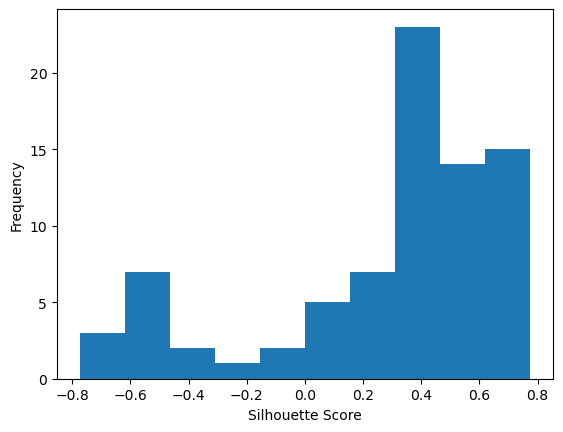

In [209]:
# Calculate the silhouette scores for each sample
scores = silhouette_samples(data[['longitude', 'latitude']], data['cluster'])

# Plot the silhouette scores as a histogram
plt.hist(scores)
plt.xlabel('Silhouette Score')
plt.ylabel('Frequency')
plt.show()

In [210]:
total_points = len(data)  
poorly_allocated_points = data[scores < -0.5] 
well_allocated_points = data[scores > -0.5] 
well_allocated_count = len(well_allocated_points)
poorly_allocated_count = len(poorly_allocated_points)  

percentage_poorly_allocated = (poorly_allocated_count / total_points) * 100

print(f"The percentage of poorly allocated points is: {percentage_poorly_allocated:.2f}%")
print(f"Count of poorly allocated points is: {poorly_allocated_count}")
print(f"The percentage of well allocated points is: {100-percentage_poorly_allocated:.2f}%")
print(f"Count of well allocated points is: {well_allocated_count}")

The percentage of poorly allocated points is: 11.39%
Count of poorly allocated points is: 9
The percentage of well allocated points is: 88.61%
Count of well allocated points is: 70
